<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#import-pkgs" data-toc-modified-id="import-pkgs-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>import pkgs</a></span></li><li><span><a href="#data-review" data-toc-modified-id="data-review-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>data review</a></span><ul class="toc-item"><li><span><a href="#train/valid-split" data-toc-modified-id="train/valid-split-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>train/valid split</a></span></li></ul></li><li><span><a href="#functions-and-experiments" data-toc-modified-id="functions-and-experiments-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>functions and experiments</a></span></li><li><span><a href="#Visulization" data-toc-modified-id="Visulization-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Visulization</a></span></li></ul></div>

## import pkgs

In [1]:
import numpy as np
import pandas as pd
import os
import glob
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from functools import reduce
import ast

from math import *

from scipy.linalg import norm
import scipy.ndimage

from ipywidgets.widgets import *
import ipywidgets as widgets

import plotly
from plotly.graph_objs import *
#import chart_studio.plotly as py

from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import cv2
from skimage import io, img_as_float, img_as_ubyte, color, exposure, measure, morphology
from skimage.measure import label, regionprops

import pydicom
from pydicom.data import get_testdata_file
from pydicom.pixel_data_handlers.util import apply_voi_lut
from pydicom import dcmread

C:\Users\echang\Anaconda3\envs\fastai_v2\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [3]:
 %config Completer.use_jedi = False

## data review

In [2]:
data_folder = 'F:\Projects\Kaggle_Siim\Data'

In [5]:
train_image_df = pd.read_csv(os.path.join(data_folder,'train_image_level.csv'))
train_study_df = pd.read_csv(os.path.join(data_folder,'train_study_level.csv'))

In [11]:
train_image_df.head(3)

id_x                                              boxes  \
0  000a312787f2_image  [{'x': 789.28836, 'y': 582.43035, 'width': 102...   
1  000c3a3f293f_image                                                NaN   
2  0012ff7358bc_image  [{'x': 677.42216, 'y': 197.97662, 'width': 867...   

                                               label StudyInstanceUID  \
0  opacity 1 789.28836 582.43035 1815.94498 2499....     5776db0cec75   
1                                     none 1 0 0 1 1     ff0879eb20ed   
2  opacity 1 677.42216 197.97662 1545.21983 1197....     9d514ce429a7   

                 id_y  Negative for Pneumonia  Typical Appearance  \
0  5776db0cec75_study                       0                   1   
1  ff0879eb20ed_study                       1                   0   
2  9d514ce429a7_study                       0                   1   

   Indeterminate Appearance  Atypical Appearance  
0                         0                    0  
1                         0                    0  
2                         0                    0

In [8]:
train_study_df.head(3)

id  Negative for Pneumonia  Typical Appearance  \
0  00086460a852_study                       0                   1   
1  000c9c05fd14_study                       0                   0   
2  00292f8c37bd_study                       1                   0   

   Indeterminate Appearance  Atypical Appearance  
0                         0                    0  
1                         0                    1  
2                         0                    0

In [10]:
#Merge study csv to image csv.
train_study_df['StudyInstanceUID'] = train_study_df['id'].apply(lambda x: x.replace('_study', ''))
train_image_df = train_image_df.merge(train_study_df, on='StudyInstanceUID')

In [12]:
# Merge image path to the train_image_level dataframe.
train_dir = os.path.join(data_folder,'train')
test_dir = os.path.join(data_folder,'test')

training_paths = []

for sid in tqdm(train_image_df['StudyInstanceUID']):
    training_paths.append(glob.glob(os.path.join(train_dir,sid+"/*/*"))[0])

train_image_df['path'] = training_paths

  0%|          | 0/6334 [00:00<?, ?it/s]

In [27]:
train_image_df.head(3)

id_x                                              boxes  \
0  000a312787f2_image  [{'x': 789.28836, 'y': 582.43035, 'width': 102...   
1  000c3a3f293f_image                                                NaN   
2  0012ff7358bc_image  [{'x': 677.42216, 'y': 197.97662, 'width': 867...   

                                               label StudyInstanceUID  \
0  opacity 1 789.28836 582.43035 1815.94498 2499....     5776db0cec75   
1                                     none 1 0 0 1 1     ff0879eb20ed   
2  opacity 1 677.42216 197.97662 1545.21983 1197....     9d514ce429a7   

                 id_y  Negative for Pneumonia  Typical Appearance  \
0  5776db0cec75_study                       0                   1   
1  ff0879eb20ed_study                       1                   0   
2  9d514ce429a7_study                       0                   1   

   Indeterminate Appearance  Atypical Appearance  \
0                         0                    0   
1                         0                    0   
2                         0                    0   

                                                path  
0  F:\Projects\Kaggle_Siim\Data\train\5776db0cec7...  
1  F:\Projects\Kaggle_Siim\Data\train\ff0879eb20e...  
2  F:\Projects\Kaggle_Siim\Data\train\9d514ce429a...

In [32]:
tt = np.array(train_image_df.iloc[0,5:9])

In [34]:
np.where(tt==1)

(array([1], dtype=int64),)

In [42]:
train_image_df['label'] = train_image_df.apply(lambda x:np.where(x.iloc[5:9]==1)[0][0], axis=1)

In [43]:
train_image_df.head(3)

id_x                                              boxes  \
0  000a312787f2_image  [{'x': 789.28836, 'y': 582.43035, 'width': 102...   
1  000c3a3f293f_image                                                NaN   
2  0012ff7358bc_image  [{'x': 677.42216, 'y': 197.97662, 'width': 867...   

   label StudyInstanceUID                id_y  Negative for Pneumonia  \
0      1     5776db0cec75  5776db0cec75_study                       0   
1      0     ff0879eb20ed  ff0879eb20ed_study                       1   
2      1     9d514ce429a7  9d514ce429a7_study                       0   

   Typical Appearance  Indeterminate Appearance  Atypical Appearance  \
0                   1                         0                    0   
1                   0                         0                    0   
2                   1                         0                    0   

                                                path  
0  F:\Projects\Kaggle_Siim\Data\train\5776db0cec7...  
1  F:\Projects\Kaggle_Siim\Data\train\ff0879eb20e...  
2  F:\Projects\Kaggle_Siim\Data\train\9d514ce429a...

<AxesSubplot:>

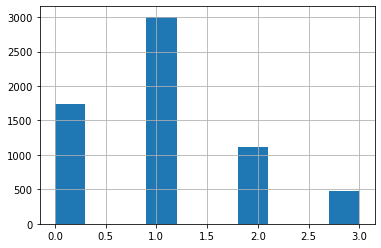

In [44]:
train_image_df.label.hist()

### train/valid split

In [45]:
import random

In [46]:
ct_groups = train_image_df.groupby('label')

In [47]:
pt_set = {}
for cls_nm,ct_group in ct_groups:
    pt_set[str(cls_nm)]={}
    pt_set[str(cls_nm)]['full'] = set(ct_group['StudyInstanceUID'])
    sl_len = round(0.1*len(set(ct_group['StudyInstanceUID'])))
    pt_set[str(cls_nm)]['select'] = random.sample(set(ct_group['StudyInstanceUID']),sl_len)

In [48]:
set_sel_bal = [i for item in [pt_set[key]['select'] for key in pt_set.keys()] for i in item]

In [51]:
train_image_df['valid_bal'] = train_image_df.apply(lambda x: 1 if x['StudyInstanceUID'] in set_sel_bal else 0, axis=1)

valid_bal
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: label, dtype: object

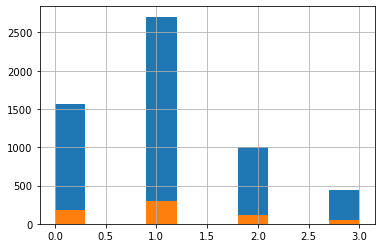

In [53]:
train_image_df.groupby('valid_bal').label.hist()

In [54]:
train_image_df.to_csv('training_bal.csv')

## functions and experiments

In [13]:
def process_dicom(dicom_obj):
    pixel_data=(0x7fe0, 0x0010) #ignore the pixel data
    data_dict={}
    for x in dicom_obj:
        if x.tag==pixel_data:
            continue
        value=dicom_obj[x.tag].value
        name=x.name
        data_dict[name]=value
    return data_dict

In [14]:
columns_reordered = list(train_image_df.columns)
complete_data = train_image_df[columns_reordered]

dicom_dict={}
needed_columns=["Patient ID","Patient's Sex","Body Part Examined","Imager Pixel Spacing",
                "Photometric Interpretation","Modality"]
# "Study Instance UID","Study ID"

for i,x in tqdm(complete_data.iterrows()):
    dicom_obj=pydicom.dcmread(x['path'],stop_before_pixels=True)
    dicom_obj_dict=process_dicom(dicom_obj)
    for key in dicom_obj_dict:
        if type(dicom_obj_dict[key])==list:
            continue
        if key in needed_columns:
            if key not in dicom_dict:
                dicom_dict[key]=[]
            dicom_dict[key].append(dicom_obj_dict[key])
            
for col in needed_columns:
    complete_data[col]=dicom_dict[col]

0it [00:00, ?it/s]

## Visulization

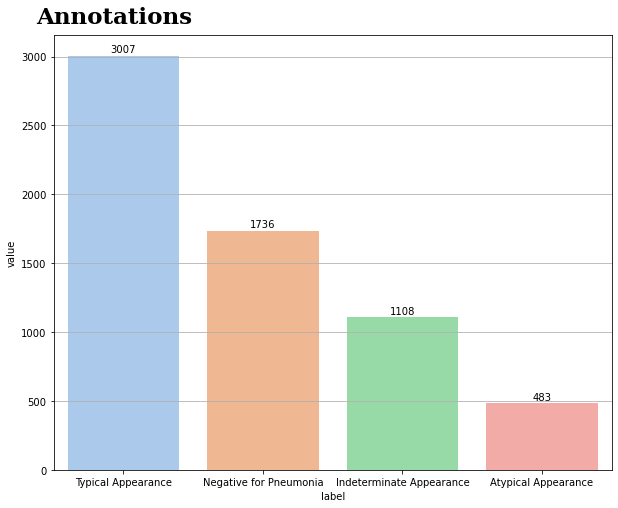

In [25]:
study_grp = pd.melt(complete_data, id_vars=list(complete_data.columns)[:1],
                         value_vars = list(complete_data.columns)[5:9],
                                           var_name='label', value_name = 'value')
study_grp = study_grp.loc[study_grp['value']!=0]
study_grp = study_grp.groupby('label').sum().sort_values('value', ascending=False).reset_index()

fig,ax = plt.subplots(1,1, figsize=(10,8))

sns.barplot(x='label', y='value', data=study_grp, palette='pastel') 
sns.color_palette('hls')

values = list(study_grp['value'])
for i, v in enumerate(values):
    ax.text(i, v+25, '%d' %v, ha='center')

fig.text(0.1,0.9, "Annotations", fontsize=23, fontweight='bold', fontfamily='serif')
plt.grid(axis='y')

plt.show()

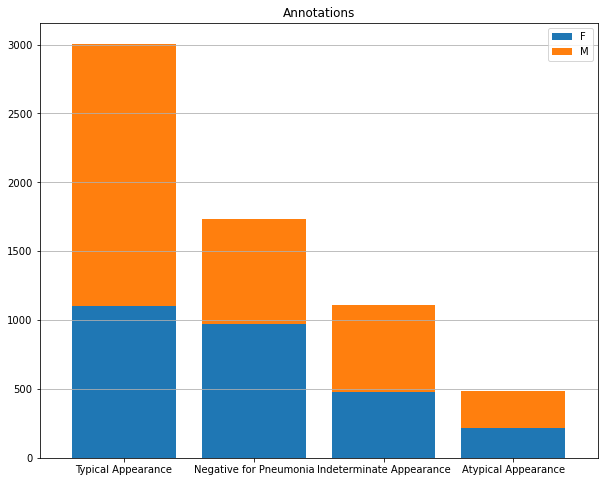

In [26]:
Negative = complete_data[complete_data['Negative for Pneumonia']==1]
Typical = complete_data[complete_data['Typical Appearance']==1]
Indeterminate = complete_data[complete_data['Indeterminate Appearance']==1]
Atypical = complete_data[complete_data['Atypical Appearance']==1]

data = pd.DataFrame({'Typical Appearance': Typical["Patient's Sex"].value_counts(),
              'Negative for Pneumonia': Negative["Patient's Sex"].value_counts(),
              'Indeterminate Appearance': Indeterminate["Patient's Sex"].value_counts(),
              'Atypical Appearance': Atypical["Patient's Sex"].value_counts()
             })
data_t = data.transpose()
ax = data_t.plot.bar(stacked = True, width=0.8,figsize=(10,8), title="Annotations")

plt.grid(axis='y')
plt.xticks(rotation=0)
plt.show()

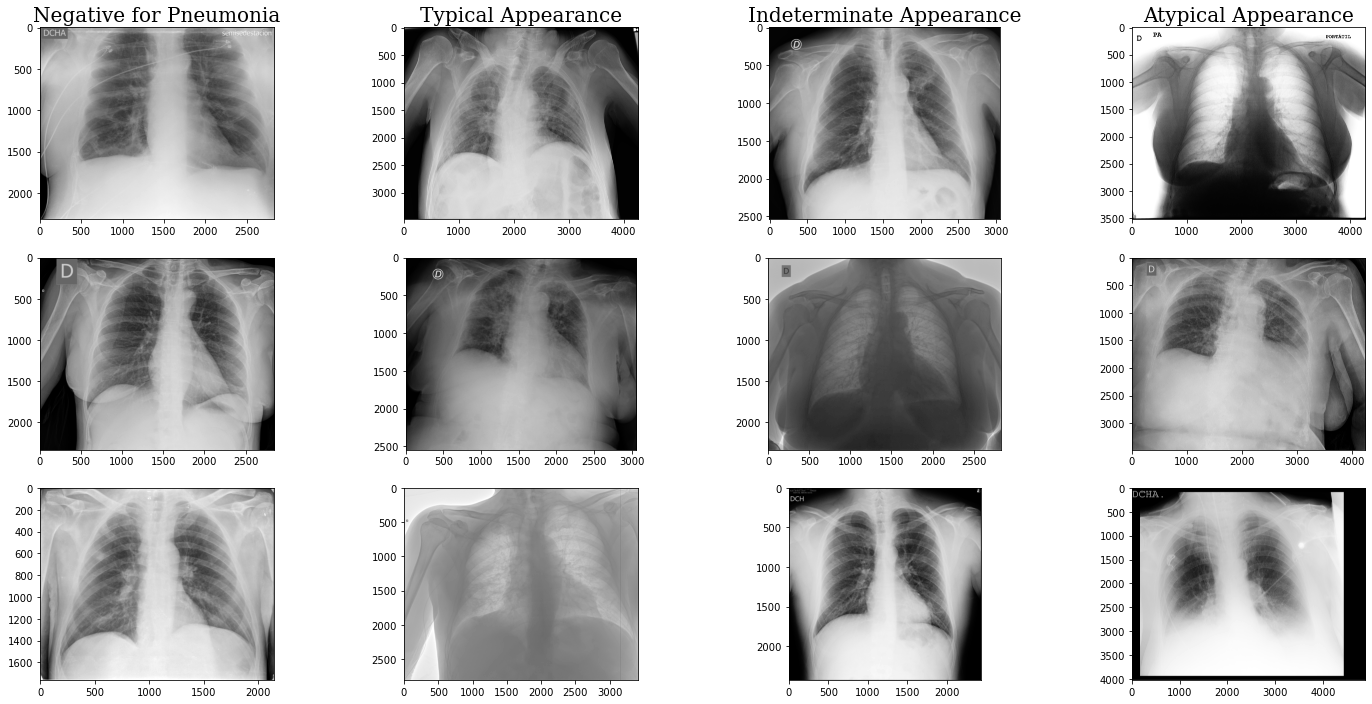

In [19]:
#Linear Rescale
label_appearance = list(complete_data.columns)[5:9]
row_img = 3
col_img = len(label_appearance)

c= 0
color = 'gray'
ds_pos = [0 for p in range(row_img)]

fig,ax = plt.subplots(row_img,col_img, figsize=(25,row_img*4))

for i in label_appearance:
    for r in range(row_img):
        link = complete_data[complete_data[i] == 1]['path'].iloc[r]
        ds_pos[r] = pydicom.dcmread(link).pixel_array
        ax[r,c].imshow(ds_pos[r], cmap=color)
        
      
    ax[0,c].set_title(i, font='Serif', fontsize=20)
    c +=1

In [20]:
complete_xy = complete_data[complete_data['label'] != 'none 1 0 0 1 1']
Typical_Appearance = complete_xy[complete_xy['Typical Appearance'] == 1].reset_index()
Indeterminate_Appearance = complete_xy[complete_xy['Indeterminate Appearance'] == 1].reset_index()
Atypical_Appearance = complete_xy[complete_xy['Atypical Appearance'] == 1].reset_index()

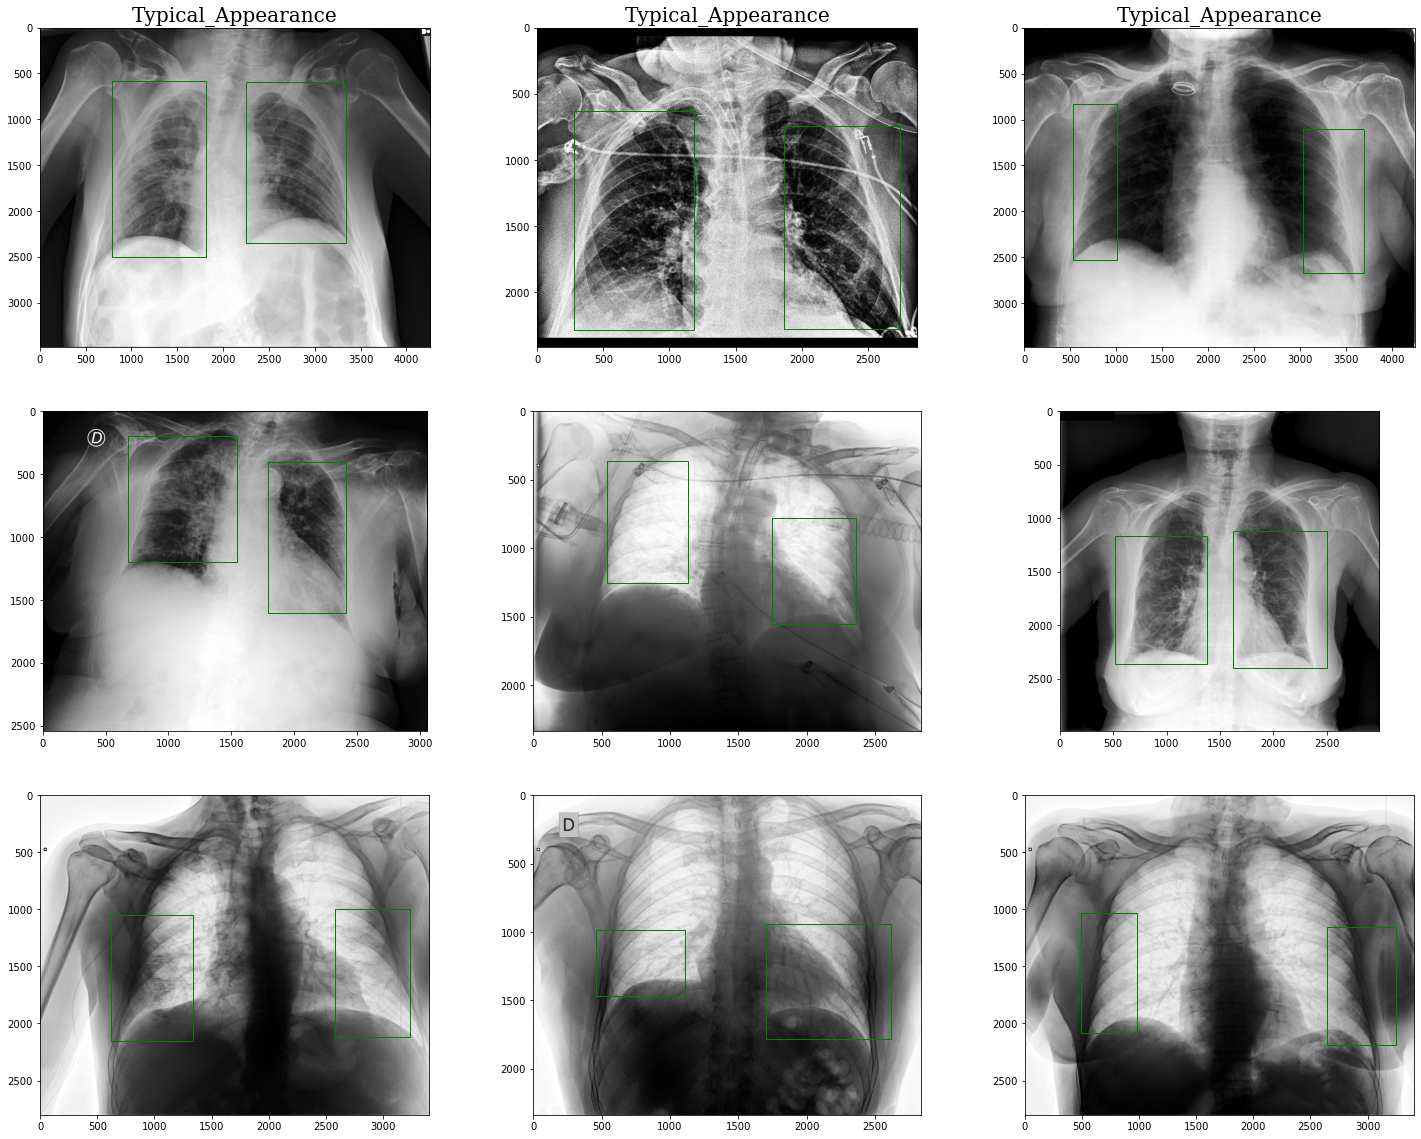

In [22]:
#Typical_Appearance

# Don't position = 200 why?!

import matplotlib

i = 0
j = 0

fig, ax = plt.subplots(3,3, figsize=(25,20))

for pos in range(9):
    
    boxes = ast.literal_eval(Typical_Appearance.loc[pos,'boxes'])
    link = Typical_Appearance['path'].iloc[pos]
    ds_pos = [0 for p in range(pos+1)]
    ds_pos[pos] = pydicom.dcmread(link).pixel_array
    img = exposure.equalize_hist(ds_pos[pos])

    for box in boxes:
        p = matplotlib.patches.Rectangle((box['x'], box['y']),
                                      box['width'], box['height'],
                                      ec='g', fc='none', lw=1)
        ax[i,j].add_patch(p)
    ax[i,j].imshow(img,cmap='gray')    
    
    i +=1      
    if i > 2:
        i = 0
        j +=1
    ax[0,i].set_title('Typical_Appearance', font='Serif', fontsize=20)

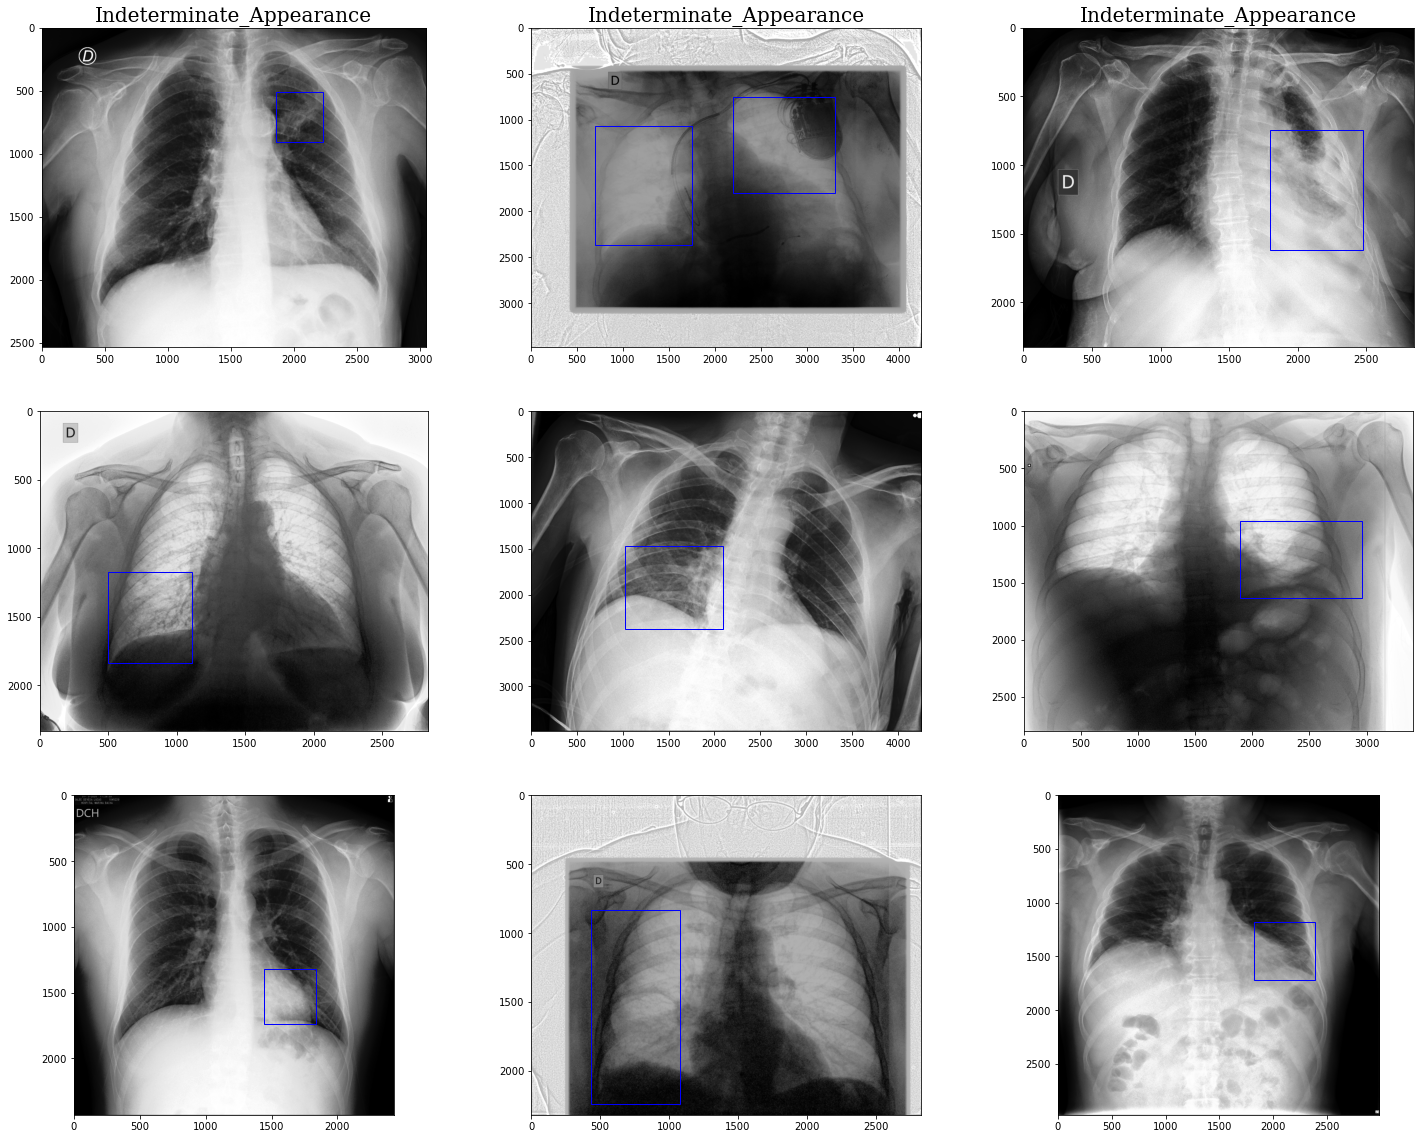

In [23]:
i = 0
j = 0

fig, ax = plt.subplots(3,3, figsize=(25,20))

for pos in range(9):
    
    boxes = ast.literal_eval(Indeterminate_Appearance.loc[pos,'boxes'])
    link = Indeterminate_Appearance['path'].iloc[pos]
    ds_pos = [0 for p in range(pos+1)]
    ds_pos[pos] = pydicom.dcmread(link).pixel_array
    img = exposure.equalize_hist(ds_pos[pos])

    for box in boxes:
        p = matplotlib.patches.Rectangle((box['x'], box['y']),
                                      box['width'], box['height'],
                                      ec='b', fc='none', lw=1)
        ax[i,j].add_patch(p)
    ax[i,j].imshow(img,cmap='gray')
    
 
    i +=1      
    if i > 2:
        i = 0
        j +=1
    ax[0,i].set_title('Indeterminate_Appearance', font='Serif', fontsize=20)

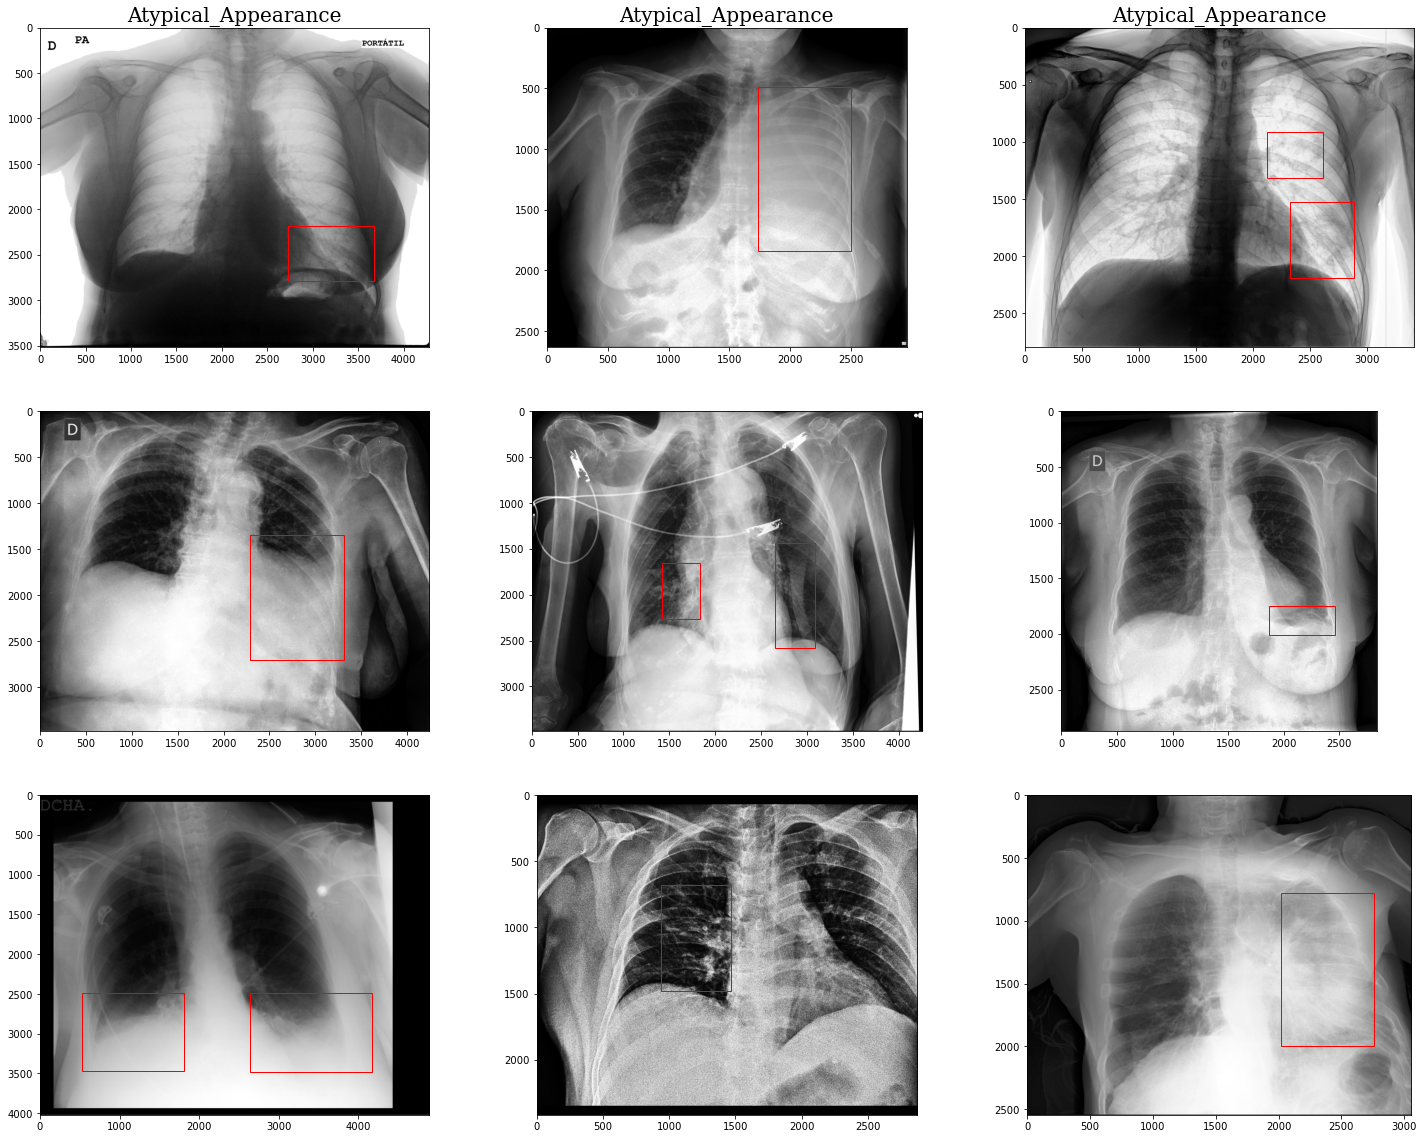

In [24]:
i = 0
j = 0

fig, ax = plt.subplots(3,3, figsize=(25,20))

for pos in range(9):
    
    boxes = ast.literal_eval(Atypical_Appearance.loc[pos,'boxes'])
    link = Atypical_Appearance['path'].iloc[pos]
    ds_pos = [0 for p in range(pos+1)]
    ds_pos[pos] = pydicom.dcmread(link).pixel_array
    img = exposure.equalize_hist(ds_pos[pos])

    for box in boxes:
        p = matplotlib.patches.Rectangle((box['x'], box['y']),
                                      box['width'], box['height'],
                                      ec='r', fc='none', lw=1)
        ax[i,j].add_patch(p)
    ax[i,j].imshow(img,cmap='gray')
    
 
    i +=1      
    if i > 2:
        i = 0
        j +=1
    ax[0,i].set_title('Atypical_Appearance', font='Serif', fontsize=20)